# Training GANs


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

**Obtain the mighty MNIST**

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

input_size = 784
num_classes = 10

batch_size = 256

train_data = dsets.MNIST(root='./MNIST/', train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_data = dsets.MNIST(root='./MNIST/', train=False, 
                           transform=transforms.ToTensor())


train_data_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                                batch_size=batch_size,
                                                drop_last=True)

test_data_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                               batch_size=batch_size,
                                               drop_last=True)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Basic visualization

In [ ]:
import torchvision

def imshow(images):
    grid = torchvision.utils.make_grid(images, nrow=5)
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

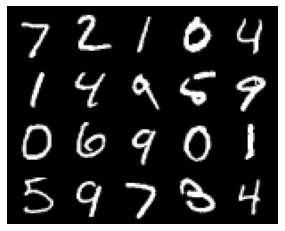

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [ ]:
number_of_samples = 20

images, labels = iter(test_data_loader).next()
images = images[:number_of_samples]
labels = labels[:number_of_samples]

imshow(images)
print(labels.numpy())

## Building the Network

### VanillaGAN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

class Generator(nn.Module):
    """
        Vanilla Generator --> fully-connected layers
    """
    def __init__(self, input_size=128, output_size=784):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_size, 128),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(128, 256),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(256, 512), 
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(512, 512), 
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(512, 1024), 
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(1024, output_size), 
                                 nn.Tanh()
                                 )
        self.input_size = input_size
        
    def forward(self, x):
        output = self.net(x)
        return output.view(-1, 1, 28, 28)

In [ ]:
class Discriminator(nn.Module):
    """
        Vanilla Generator --> fully-connected layers
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_size, 512),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(512, 256),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(256, 512), 
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(512, 512), 
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(512, num_classes), 
                                 nn.Sigmoid()
                                 )
    
    def forward(self, x):
        flatten = x.view(x.size(0), -1)
        output = self.net(flatten)
        return output

### Defining the loss function

In [ ]:
def losses(G, D, x_batch, criterion):
    z = torch.randn(batch_size, G.input_size).to(device)
    trues = torch.ones(x_batch.shape[0], 1).to(device)
    falses = torch.zeros(x_batch.shape[0], 1).to(device)
    
    generated = G(z)

    predicted_trues = D(x_batch.to(device))
    predicted_falses = D(generated)

    true_loss = criterion(predicted_trues, trues)
    fake_loss = criterion(predicted_falses, falses)
    
    D_loss = true_loss + fake_loss

    # G_loss = -criterion(predicted_falses, false)
    G_loss = criterion(predicted_falses, trues)
    
    return D_loss, G_loss
    

### Training process

Keep in mind, that sometimes we are need to train Discriminator and Generator at different speed aka. with different ratios. But for now let's keep it simple.

# Hometask Bonus

Implement the different proportion between learning discriminator and generator

In [ ]:
raise NotImplementedError

#### Implement Test Function

In [ ]:
def test_batch(G, D, criterion):
  
    G_loss_log = [] 
    D_loss_log = []
    
    G.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_data_loader):
        D_loss, G_loss = losses(G, D, x_batch, criterion)
        
        D_loss_log += [D_loss.item()]
        G_loss_log += [G_loss.item()]
    return D_loss_log, G_loss_log 

#### Implement Loss Function Visualisation

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_history[0], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Discriminator loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_history[1], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 2], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Generator loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.show()

### Finally train

In [ ]:
def train(G, D, G_opt, D_opt, criterion, n_epochs):
    train_log = [[], []]
    val_log = []
    
    for epoch in range(n_epochs):
        train_loss = train_epoch(G, D, G_opt, D_opt, criterion, batch_size=batch_size)
        val_loss = test_batch(G, D, criterion)
        
        train_log[0].extend(train_loss[0])
        train_log[1].extend(train_loss[1])
        
        steps = train_data.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss[0]), np.mean(val_loss[1])))
        
        clear_output()
        plot_history(train_log, val_log)    

Check for GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Define Generator & Discriminator & optimizers & criterion

In [ ]:
batch_size

256

In [ ]:
input_size = 128

D = Discriminator().to(device)
G = Generator(input_size).to(device)

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

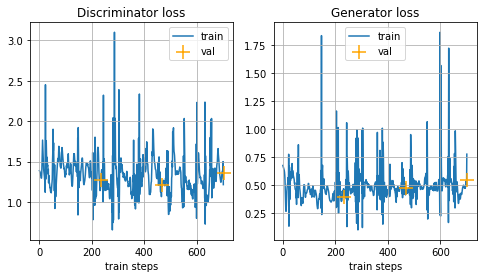

In [ ]:
train(G, D, G_opt, D_opt, criterion, 3)

Visualisation

In [ ]:
def visualization(test_data_loader, G):
    number_of_samples = 5

    images, _ = iter(test_data_loader).next()
    z = torch.randn(number_of_samples, G.input_size).to(device)
    gen_images = G(z)
    images = images[:number_of_samples]

    imshow(images)
    imshow(gen_images.detach().cpu())

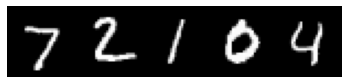

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


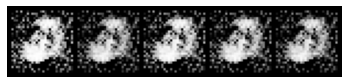

In [ ]:
visualization(test_data_loader, G)

resourses: **[eriklindernoren](https://github.com/eriklindernoren/PyTorch-GAN)**, **[Yangyangii](https://github.com/Yangyangii/GAN-Tutorial)**, **aosokin**

# HomeTask 1

Implement a DCGAN

In [ ]:
class dcGenerator(nn.Module):
    """
       DCGAN Generator  --> use convolutions
    """
    raise NotImplementedError

In [ ]:
class dcDiscriminator(nn.Module):
    """
       DCGAN Discriminator  --> use convolutions
    """
    raise NotImplementedError

# HomeTask 2

Compare the learning process and final images to a fully-connected GAN

In [ ]:
raise NotImplementedError

## Conditional GANs

In [ ]:
class cGenerator(nn.Module):
    """
        Conditional GAN generator --> concated input
    """
    def __init__(self, input_size=100, condition_size=10, num_classes=784):
        super(cGenerator, self).__init__()

        self.label_embedding = nn.Embedding(condition_size, condition_size)
        self.net = nn.Sequential(
            nn.Linear(input_size+condition_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        self.input_size = input_size
        
        
    def forward(self, x, c):
        c = self.label_embedding(c)
        x = torch.cat([x,c], 1)
        output = self.net(x)
        return output

In [ ]:
class cDiscriminator(nn.Module):
    """
        Conditional GAN discriminator --> concated input
    """
    def __init__(self, input_size=784, condition_size=10, num_classes=1):
        super(cDiscriminator, self).__init__()
        
        self.label_embedding = nn.Embedding(condition_size, condition_size)

        self.net = nn.Sequential(
            nn.Linear(input_size+condition_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x, c):        
        c = self.label_embedding(c)
        x = torch.cat([x,c], 1)
        output = self.net(x)
        return output

In [ ]:
def to_onehot(x, num_classes=10):
    c = nn.Embedding(num_classes, num_classes)(x)
    return c

In [ ]:
condition_size = 10
input_size = 784

cD = cDiscriminator(condition_size=condition_size).to(device)
cG = cGenerator(input_size, condition_size).to(device)

criterion = nn.BCELoss()
cD_opt = torch.optim.Adam(cD.parameters(), lr=0.0002, betas=(0.5, 0.999))
cG_opt = torch.optim.Adam(cG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
def losses(G, D, x_batch, labels, criterion):
    batch_size = x_batch.shape[0]
    z = torch.randn(batch_size, G.input_size).to(device)
    trues = torch.ones(x_batch.shape[0], 1).to(device)
    falses = torch.zeros(x_batch.shape[0], 1).to(device)
    
    gen_labels = torch.randint(0, 10, (batch_size,)).to(device)
    generated = G(z, gen_labels)

    x_batch = x_batch.view(batch_size, G.input_size).to(device)
    predicted_trues = D(x_batch, labels.to(device))
    predicted_falses = D(generated, gen_labels)

    true_loss = criterion(predicted_trues, trues)
    fake_loss = criterion(predicted_falses, falses)
    
    D_loss = true_loss + fake_loss

    G_loss = criterion(predicted_falses, trues)
    
    return D_loss, G_loss
    

def train_epoch(G, D, G_opt, D_opt, criterion, batch_size=32):
    
    G_loss_log = [] 
    D_loss_log = []
    
    G.train()
    for batch_num, (images, labels) in zip(trange(len(train_data_loader)), 
                                                  train_data_loader):
        x_batch = images.float()
        D_loss, G_loss = losses(G, D, x_batch, labels, criterion)
            
        D_opt.zero_grad()
        D_loss.backward(retain_graph=True)
        
        G_opt.zero_grad()
        G_loss.backward()

        D_opt.step()
        G_opt.step()
            
        D_loss_log += [D_loss.item()]
        G_loss_log += [G_loss.item()]
        
    return D_loss_log, G_loss_log 
  
def test_batch(G, D, criterion):
    G_loss_log = [] 
    D_loss_log = []
    
    G.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_data_loader):
        D_loss, G_loss = losses(G, D, x_batch, y_batch, criterion)
        
        D_loss_log += [D_loss.item()]
        G_loss_log += [G_loss.item()]
    return D_loss_log, G_loss_log 

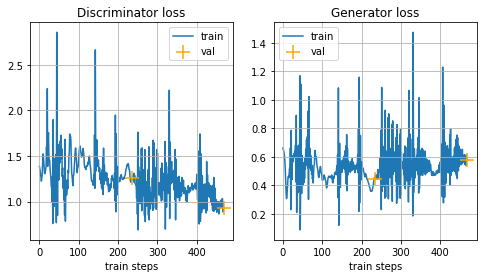

In [ ]:
train(cG, cD, cG_opt, cD_opt, criterion, 2)

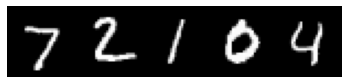

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


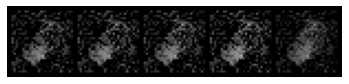

tensor([7, 2, 1, 0, 4])


In [ ]:
number_of_samples = 5

images, labels = iter(test_data_loader).next()
labels = labels[:number_of_samples]
z = torch.randn(number_of_samples, cG.input_size).to(device)
gen_images = cG(z, labels.to(device))
images = images[:number_of_samples]

imshow(images)
imshow(gen_images.view(number_of_samples, 1, 28, 28).cpu().detach())
print(labels)

# HomeTask 3

Find/implement any other type of GAN ((almost) full list of pytorch implementations [here](https://github.com/eriklindernoren/PyTorch-GAN)). Train chosen GAN on any type of data (preferably something more complicated than MNIST, ideally -- your own dataset: your image class, syntetic images, etc). 

Play with arcitecture choises, number of epochs, otimazers, etc and come up with the model that suits your problem best. Write a conclusion on why the GANs are nessesarily in your task and why chosed GAN is better than everything else. 

In [ ]:
raise NotImplementedError